In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Imports necessary for training the model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as ds
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

# Few other important libraries
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

torch.manual_seed(42)

In [3]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
dataset_path = "/kaggle/input/deep-learning-practice-image-classification/"

# Load Dataset

In [5]:
train_folder = ds.ImageFolder(root=os.path.join(dataset_path, "train"), transform=transform)
train_ds = DataLoader(train_folder, batch_size=16, shuffle=True)
# test_dataset = ds.ImageFolder(root=os.path.join(dataset_path, "test"), transform=transform)

In [6]:
label_map = {
    0: "Amphibia",
    1: "Animalia",
    2: "Arachnida",
    3: "Aves",
    4: "Fungi",
    5: "Insecta",
    6: "Mammalia",
    7: "Mollusca",
    8: "Plantae",
    9: "Reptilia"
}

In [7]:
# Create a validation set from the training data
train_size_fraction = 0.8
train_size = int(train_size_fraction*len(train_ds))  # 80% for training
val_size = len(train_ds) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_ds, [train_size, val_size])

In [8]:
len(train_ds)==len(train_dataset)+len(val_dataset)

True

In [9]:
batch_size = 16 # Batch Size of the images

# Creating dataloaders
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = True)
# test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

# Printing the no. of samples in each dataset
print("No. of samples in training dataset:", len(train_loader.dataset))
print("No. of samples in validation dataset:", len(val_loader.dataset))
# print("No. of samples in test dataset:", len(test_loader.dataset))

No. of samples in training dataset: 500
No. of samples in validation dataset: 125


In [10]:
for image, label in train_loader.dataset.dataset:
    print(label)
    print(image[0].shape)
    break
    

tensor([9, 3, 0, 8, 5, 5, 4, 3, 0, 3, 0, 3, 3, 9, 1, 3])
torch.Size([3, 227, 227])


# Useful Functions

In [11]:
def inverse_normalize(image, mean, std):
    '''
    Function:- Used to invert the normalization for an image to retrieve the original image
    
    Inputs:-
    image: Normalized Image
    mean: Mean of RGB Channels
    std: Standard Deviation of RGB Channels
    return: image with pixels between 0 and 1
    '''
    for i in range(image.shape[0]):
        image[i] = image[i] * std[i] + mean[i]
    return image.clamp(0, 1)  # Ensure values are within [0, 1]

def show_image(idx, dataset):
    original_image = dataset.dataset.dataset[idx][0]
    original_label = dataset.dataset.dataset[idx][1]
    plt.imshow(np.transpose(original_image, (1,2,0)))
    plt.title(f'Original: {label_map[original_label]}')

def calculate_correct_predictions(out, labels):
    '''
    Function:- Calculates the no. of correct predictions
    
    Inputs:-
    out: Output from the model
    labels: True labels
    
    Output: Count of correct predictions
    '''
    _, pred = torch.max(out, dim=1)
    return pred

def epoch_time(start_time, end_time):
    '''
    Function:- Calculates the time between two timestamps
    
    Inputs:-
    start_time: Timestamp at the start
    end_time: Timestamp at the end
    
    returns: Elapsed minutes and seconds
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def load_stored_model(model_name, filepath, device='cuda'):
    '''
    Function: Loads the stored model (trained in the past)
    
    Inputs:-
    model_name: Name of model
    filepath: Path of the stored model
    device: Device on which the model has to be used
    
    Returns: 
    Model loaded with weights and ready for testing
    '''
    model = create_model(model_name)
    model.load_state_dict(torch.load(filepath))
    return model

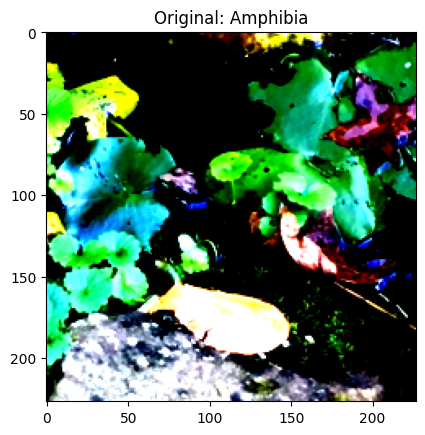

In [12]:
# show image 

show_image(900, train_dataset)

In [13]:
# We need to ensure whether the GPU from Kaggle is available or not
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Model will be trained using {device}.")

Model will be trained using cuda.


# Train the Model

In [14]:
def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    '''
    Function:- Trains the given model with given data and hyperparameters
    
    Inputs:-
    model: PyTorch Model
    train_loader: Dataloader of Training Data
    val_loader: Dataloader of Validation Data
    criterion: Loss Function
    optimizer: Optimizer for training
    num_epochs: No. of epochs
    device: Device for training
    save_path: Path for saving the best model
    
    Outputs-
    model: Trained model
    Training cost, Training Accuracy and Validation Accuracy at each Epoch
    '''
    # Variables useful for plotting later
    cost_train_list = []
    accuracy_train_list = []
    accuracy_val_list = []
    f1_train_list = []
    f1_val_list = []
    
    # Best accuracy to determine whether model has to be stored or not
    best_f1_score = 0
    start_time = time.time() # Timestamp for start of the training
    save_path = f'best_model_{model_name.lower()}.pth'
    print(f"Model will be saved as '{save_path}'")
    
    # Iterating through each epoch
    for epoch in range(1, num_epochs+1):
        print(f"------------------------ Epoch No. {epoch} ------------------------")
        start_epoch = time.time() # Timestamp for start of current epoch
        running_loss = 0
        correct_train, correct_val = 0, 0

        true_labels = []
        pred_labels = []
        # tqdm library is used for displaying the progress bar
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch}/{num_epochs}', unit='batch') as tepoch:
            # Iterating through each batch
            
            for images, labels in train_loader.dataset.dataset:
                images = images.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                # Output is obtained
                outputs = model(images)
                
                # Loss is calculated and propagated backwards
                loss = criterion(outputs, labels)
                loss.backward()
                running_loss += loss.item()
                
                # Gradients are updated
                optimizer.step()
                
                # No. of correct predictions are calculated
                pred_train = calculate_correct_predictions(outputs, labels)
                correct_train += torch.sum(pred_train==labels).item()
                true_labels.extend(labels.cpu().numpy())
                pred_labels.extend(pred_train.cpu().numpy())
                images.cpu(), labels.cpu()
                tepoch.set_postfix(loss=running_loss / (tepoch.n + 1), accuracy=(correct_train / ((tepoch.n + 1) * train_loader.batch_size)) * 100)  # Update progress bar with current loss
                tepoch.update()  # Increment the progress bar
                

            # Training accuracy is calculated and stored
            cost_train_list.append(running_loss)
            acc_train = accuracy_score(true_labels, pred_labels)
            accuracy_train_list.append(acc_train)
            f1_train = f1_score(true_labels, pred_labels, average="macro")
            f1_train_list.append(f1_train)
            print(f"\nEpoch {epoch}: Accuracy on Train Set = {acc_train:.2f} %, Training Cost = {running_loss:.2f}")
            print(f"Epoch {epoch}: F1 Score on Train Set = {f1_train:.2f} %")
            # Performance on validation dataset is checked
            print(f"Validation begins for Epoch {epoch}...")


            true_labels = []
            pred_labels = []
            
            # 'torch.no_grad()' is used to disable gradient calculation during the inference or testing phase
            with torch.no_grad():
                # Iterating through each batch
                for x_val, y_val in val_loader.dataset.dataset:
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    
                    # Output is obtained
                    z = model(x_val)
                    # Correct no. of predictions is calculated
                    pred_val = calculate_correct_predictions(z, y_val)
                    true_labels.extend(y_val.cpu().numpy())
                    pred_labels.extend(pred_val.cpu().numpy())
                    correct_val+=torch.sum(pred_val==y_val).item()
                    x_val.cpu(), y_val.cpu()

            # Validation dataset's accuracy is calculated and stored
            acc_val = accuracy_score(true_labels, pred_labels)
            accuracy_val_list.append(acc_val)
            f1_val = f1_score(true_labels, pred_labels, average="macro")
            f1_val_list.append(f1_val)
            
            # If current epoch's validation set accuracy is greater than best accuracy, current model is saved.
            if f1_val > best_f1_score:
                best_f1_score = f1_val
                torch.save(model.state_dict(), save_path)
                print(f"Model saved with accuracy: {best_f1_score:.2f} %")
            
            print(f"Epoch {epoch}: Accuracy on Validation Set = {acc_val:.2f} %")
            print(f"Epoch {epoch}: F1 Score on Validation Set = {f1_val:.2f} %")
            end_epoch = time.time()
            epoch_mins, epoch_secs = epoch_time(start_epoch, end_epoch)
            print(f"Runtime for Epoch {epoch}: {epoch_mins} minutes and {epoch_secs} seconds.\n")
            torch.cuda.empty_cache()

    end_time = time.time() # Timestamp for the end of the training phase
    total_mins, total_secs = epoch_time(start_time, end_time)
    print(f"\nTotal Runtime: {total_mins} minutes and {total_secs} seconds.")
    
    return model, [cost_train_list, accuracy_train_list, accuracy_val_list, f1_train_list, f1_val_list]

In [15]:
# m = models.resnet152(weights="IMAGENET1K_V1")
# m.fc

In [16]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNet, self).__init__()
        self.base_model=models.efficientnet_v2_l(pretrained=True)
            
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.classifier[1].in_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes),
            nn.Sigmoid()
        )
        
        # self.cf = CNNHead(num_classes)
    def forward(self, x):
        x = self.base_model(x)
        return x
        

num_classes=len(label_map)
model = EfficientNet(num_classes)
# print(model.base_model.classifier)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:02<00:00, 209MB/s]


In [17]:
model_name = 'EfficientNet_10_ft'

In [18]:
# Load stored model
# model_name = 'EfficientNet_full_ft'
# model_path = f"/kaggle/working/best_model_{model_name.lower()}.pth"
# model = EfficientNet(len(label_map))
# model.load_state_dict(torch.load(model_path));

In [19]:
model.to(device);

In [20]:
# For this tutorial, we will train the model for 8 epochs. We also have another version of this model trained for 60 epochs.

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
num_epochs = 10
model_name = 'EfficientNet_full_ft'

# Trained model and data for plotting is obtained
model, training_curves_list = train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs, device) 

Model will be saved as 'best_model_efficientnet_full_ft.pth'
------------------------ Epoch No. 1 ------------------------


Epoch 1/10: 625batch [11:30,  1.10s/batch, accuracy=68, loss=1.76]


Epoch 1: Accuracy on Train Set = 0.68 %, Training Cost = 1098.05
Epoch 1: F1 Score on Train Set = 0.68 %
Validation begins for Epoch 1...


Epoch 1/10: 625batch [15:37,  1.50s/batch, accuracy=68, loss=1.76]


Model saved with accuracy: 0.80 %
Epoch 1: Accuracy on Validation Set = 0.80 %
Epoch 1: F1 Score on Validation Set = 0.80 %
Runtime for Epoch 1: 15 minutes and 37 seconds.

------------------------ Epoch No. 2 ------------------------


Epoch 2/10: 625batch [10:10,  1.03batch/s, accuracy=80.2, loss=1.62]


Epoch 2: Accuracy on Train Set = 0.80 %, Training Cost = 1014.84
Epoch 2: F1 Score on Train Set = 0.80 %
Validation begins for Epoch 2...


Epoch 2/10: 625batch [14:17,  1.37s/batch, accuracy=80.2, loss=1.62]


Model saved with accuracy: 0.83 %
Epoch 2: Accuracy on Validation Set = 0.83 %
Epoch 2: F1 Score on Validation Set = 0.83 %
Runtime for Epoch 2: 14 minutes and 17 seconds.

------------------------ Epoch No. 3 ------------------------


Epoch 3/10: 625batch [10:09,  1.05batch/s, accuracy=84.3, loss=1.59]


Epoch 3: Accuracy on Train Set = 0.84 %, Training Cost = 992.27
Epoch 3: F1 Score on Train Set = 0.84 %
Validation begins for Epoch 3...


Epoch 3/10: 625batch [14:14,  1.37s/batch, accuracy=84.3, loss=1.59]


Model saved with accuracy: 0.87 %
Epoch 3: Accuracy on Validation Set = 0.87 %
Epoch 3: F1 Score on Validation Set = 0.87 %
Runtime for Epoch 3: 14 minutes and 13 seconds.

------------------------ Epoch No. 4 ------------------------


Epoch 4/10: 625batch [10:07,  1.05batch/s, accuracy=86.9, loss=1.57]


Epoch 4: Accuracy on Train Set = 0.87 %, Training Cost = 978.49
Epoch 4: F1 Score on Train Set = 0.87 %
Validation begins for Epoch 4...


Epoch 4/10: 625batch [14:12,  1.36s/batch, accuracy=86.9, loss=1.57]


Model saved with accuracy: 0.89 %
Epoch 4: Accuracy on Validation Set = 0.89 %
Epoch 4: F1 Score on Validation Set = 0.89 %
Runtime for Epoch 4: 14 minutes and 12 seconds.

------------------------ Epoch No. 5 ------------------------


Epoch 5/10: 625batch [10:06,  1.04batch/s, accuracy=88.3, loss=1.55]


Epoch 5: Accuracy on Train Set = 0.88 %, Training Cost = 971.12
Epoch 5: F1 Score on Train Set = 0.88 %
Validation begins for Epoch 5...


Epoch 5/10: 625batch [14:14,  1.37s/batch, accuracy=88.3, loss=1.55]


Model saved with accuracy: 0.90 %
Epoch 5: Accuracy on Validation Set = 0.90 %
Epoch 5: F1 Score on Validation Set = 0.90 %
Runtime for Epoch 5: 14 minutes and 13 seconds.

------------------------ Epoch No. 6 ------------------------


Epoch 6/10: 625batch [10:06,  1.06batch/s, accuracy=88.8, loss=1.55]


Epoch 6: Accuracy on Train Set = 0.89 %, Training Cost = 966.46
Epoch 6: F1 Score on Train Set = 0.89 %
Validation begins for Epoch 6...


Epoch 6/10: 625batch [14:10,  1.36s/batch, accuracy=88.8, loss=1.55]


Model saved with accuracy: 0.91 %
Epoch 6: Accuracy on Validation Set = 0.91 %
Epoch 6: F1 Score on Validation Set = 0.91 %
Runtime for Epoch 6: 14 minutes and 10 seconds.

------------------------ Epoch No. 7 ------------------------


Epoch 7/10: 625batch [10:13,  1.04batch/s, accuracy=90.9, loss=1.53]


Epoch 7: Accuracy on Train Set = 0.91 %, Training Cost = 958.10
Epoch 7: F1 Score on Train Set = 0.91 %
Validation begins for Epoch 7...


Epoch 7/10: 625batch [14:25,  1.38s/batch, accuracy=90.9, loss=1.53]


Model saved with accuracy: 0.92 %
Epoch 7: Accuracy on Validation Set = 0.92 %
Epoch 7: F1 Score on Validation Set = 0.92 %
Runtime for Epoch 7: 14 minutes and 24 seconds.

------------------------ Epoch No. 8 ------------------------


Epoch 8/10: 625batch [10:11,  1.01batch/s, accuracy=91.9, loss=1.52]


Epoch 8: Accuracy on Train Set = 0.92 %, Training Cost = 952.79
Epoch 8: F1 Score on Train Set = 0.92 %
Validation begins for Epoch 8...


Epoch 8/10: 625batch [14:21,  1.38s/batch, accuracy=91.9, loss=1.52]


Model saved with accuracy: 0.94 %
Epoch 8: Accuracy on Validation Set = 0.94 %
Epoch 8: F1 Score on Validation Set = 0.94 %
Runtime for Epoch 8: 14 minutes and 21 seconds.

------------------------ Epoch No. 9 ------------------------


Epoch 9/10: 625batch [10:09,  1.04batch/s, accuracy=92.5, loss=1.52]


Epoch 9: Accuracy on Train Set = 0.92 %, Training Cost = 951.23
Epoch 9: F1 Score on Train Set = 0.92 %
Validation begins for Epoch 9...


Epoch 9/10: 625batch [14:13,  1.36s/batch, accuracy=92.5, loss=1.52]


Epoch 9: Accuracy on Validation Set = 0.92 %
Epoch 9: F1 Score on Validation Set = 0.92 %
Runtime for Epoch 9: 14 minutes and 12 seconds.

------------------------ Epoch No. 10 ------------------------


Epoch 10/10: 625batch [10:07,  1.06batch/s, accuracy=93.3, loss=1.51]


Epoch 10: Accuracy on Train Set = 0.93 %, Training Cost = 946.62
Epoch 10: F1 Score on Train Set = 0.93 %
Validation begins for Epoch 10...


Epoch 10/10: 625batch [14:11,  1.36s/batch, accuracy=93.3, loss=1.51]

Model saved with accuracy: 0.94 %
Epoch 10: Accuracy on Validation Set = 0.94 %
Epoch 10: F1 Score on Validation Set = 0.94 %
Runtime for Epoch 10: 14 minutes and 11 seconds.


Total Runtime: 143 minutes and 58 seconds.


# Plot Training Curves

In [21]:
def plot_training_curves(training_curves_list, model_name=""):
    '''
    Function: Plots the training loss and accuracy for training and validation data vs. Epochs
    
    Inputs:-
    training_curves_list: List containing data for plotting
    model_name: Name of model
    
    Output:-
    Creates two plots
    '''
    # Create the variables for accuracy and cost data
    cost_train_list = training_curves_list[0]
    accuracy_train_list = training_curves_list[1]
    accuracy_val_list = training_curves_list[2]
    
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 12))

    # Plot for training cost function with epochs
    axs[0].plot(np.arange(1, num_epochs + 1, 1), cost_train_list, marker=".", markersize="8", label="Training Loss", color="red")
    axs[0].set_xlabel('Epochs', fontsize=15)
    axs[0].set_ylabel("Training Loss", fontsize=15)
    axs[0].set_title('Training Loss', color="blue")
    axs[0].grid(linestyle='--')
    axs[0].legend()

    # Plot for training and validation accuracy with epochs
    axs[1].plot(np.arange(1, num_epochs + 1, 1), accuracy_train_list, marker=".", markersize="8", label="Training Dataset Accuracy", color="blue")
    axs[1].plot(np.arange(1, num_epochs + 1, 1), accuracy_val_list, marker=".", markersize="8", label="Validation Dataset Accuracy", color="green")
    axs[1].set_xlabel('Epochs', fontsize=15)
    axs[1].set_ylabel("Accuracy (in %)", fontsize=15)
    axs[1].set_title('Training and Validation Accuracy', color="blue")
    axs[1].grid(linestyle='--')
    axs[1].legend()

    # Adjust layout
    plt.tight_layout()

    # Save the figure
    plt.savefig(f"Training_Validation_Accuracy_and_Cost_for_{model_name.lower()}.jpg", dpi=500)

    # Show the plot
    plt.show()

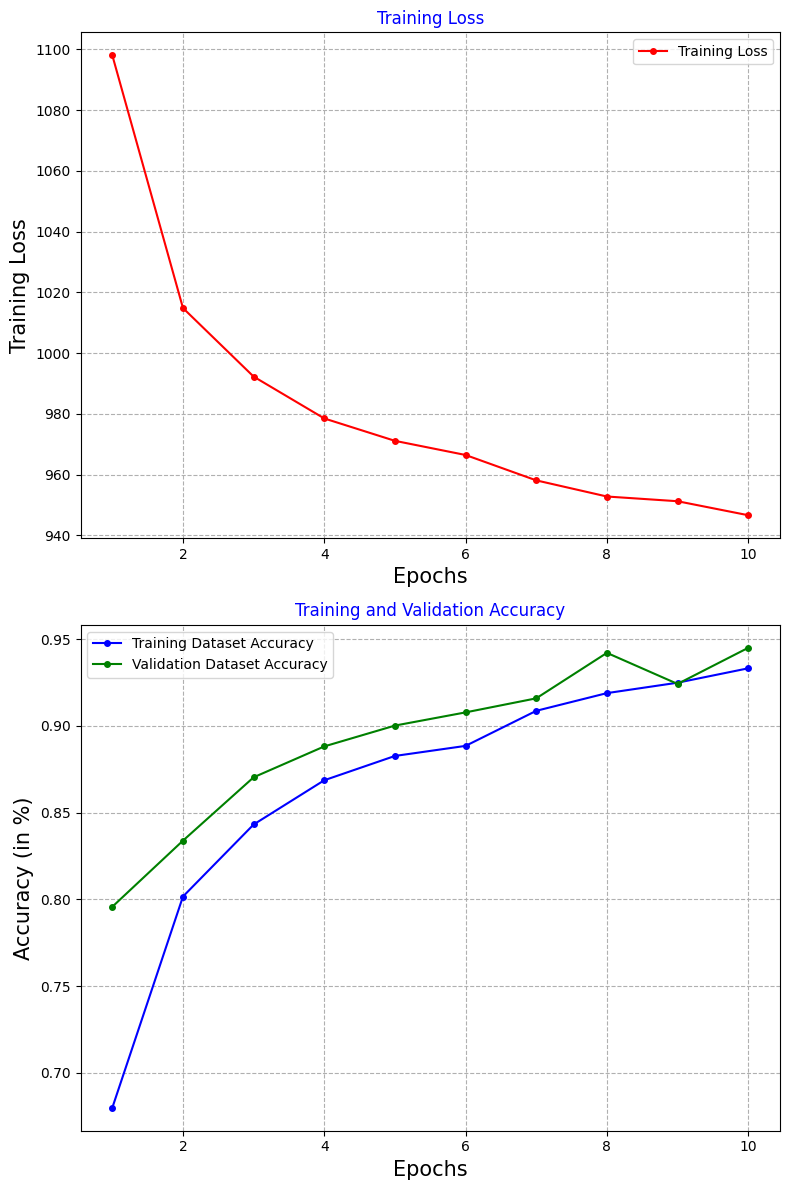

In [22]:
plot_training_curves(training_curves_list)

In [23]:
test_path=dataset_path+"/test/"
img_list = os.listdir(test_path)
test_loader = DataLoader(dataset = img_list, batch_size = 16, shuffle = False)

In [24]:
from PIL import Image

In [25]:
class CustomImageDataset(Dataset):
    def __init__(self, folder, transform):
        self.folder = folder
        self.image_files = sorted([f for f in os.listdir(folder) if f.endswith('.jpg')])
        self.transform = transform
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.image_files[idx])
        image = Image.open(img_path)# .convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx].split(".")[0]

# Load the dataset
test_dataset = CustomImageDataset(test_path, transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [26]:
test_loader.dataset


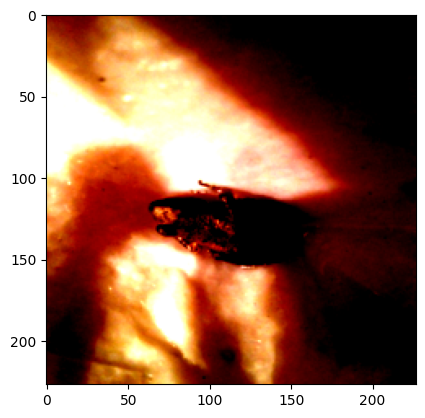

In [27]:
original_image=test_loader.dataset[0][0]

plt.imshow(np.transpose(original_image, (1,2,0)))



In [28]:
def evaluate_model(model, test_loader, device):
    '''
    Function:- Evaluates the given model on test dataset
    
    Inputs:-
    model: Trained model
    test_loader: Dataloader of Test Data
    device: Device for testing the model
    label_map: Mapping of labels to class names
    model_name: Name of model
    num_classes: No. of classes
    
    Output:-
    Displays confusion matrix and prints classification report
    '''
    model.eval()  # Set the model to evaluation mode
    img_ids = []
    pred_labels = []
    space_sep_model_name = model_name.replace('_', ' ')

    # Gradient calculation is disabled
    with torch.no_grad():
        # Iterating through each batch of test dataloader
        for x_test, img in test_loader:
            x_test = x_test.to(device)
            
            # Output is obtained
            z = model(x_test)
            
            # Predicted labels are collected
            _, predicted = torch.max(z.data, 1)
            
            # Current batch's labels and predictions are stored
            pred_labels.extend(predicted.cpu().numpy())
            img_ids.extend(img)
    return img_ids, pred_labels

In [29]:
img_ids, pred_labels = evaluate_model(model, test_loader, device)

In [30]:
import random

x = img_ids 
y = pred_labels

df = pd.DataFrame({"Image_ID":x, "Label":y})

In [31]:
df.to_csv("submission.csv", index=False)

In [32]:
ls -lh

total 459M
-rw-r--r-- 1 root root 878K Nov 27 04:07 Training_Validation_Accuracy_and_Cost_for_.jpg
---------- 1 root root 2.8M Nov 27 04:09 __notebook__.ipynb
-rw-r--r-- 1 root root 455M Nov 27 04:07 best_model_efficientnet_full_ft.pth
-rw-r--r-- 1 root root  26K Nov 27 04:09 submission.csv


In [33]:
ls

Training_Validation_Accuracy_and_Cost_for_.jpg
__notebook__.ipynb
best_model_efficientnet_full_ft.pth
submission.csv
